# **Fundamental loss function for change point detection**
## Final project for Skoltech 2021 ML course by prof. Burnaev, prof. Zaycev
## By "Prove you are not a robot" team


In [33]:
!pip install ruptures

     |████████████████████████████████| 921kB 5.7MB/s 


In [39]:
import numpy as np
from sklearn.metrics import precision_score, recall_score
import xgboost as xgb
from typing import Tuple
from numba import jit
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
import random
from random import randint
from tqdm import tqdm
import ruptures as rpt

### Adjusting existing dataset (USC-SIPI human activity dataset) to our goals

In [40]:
def get_cp_set(state_1, state_2, features, set_len=1000, len_join=20):
    random.seed(5)
    len_slice_1 = randint(len_join, set_len - 2 * len_join)
    len_slice_2 = set_len - len_slice_1 - len_join
    
    cpd = {i: [] for i in features}
    
    a1 = randint(0, len(state_1['acc_x']) - len_slice_1)
    
    a2 = randint(0, len(state_2['acc_x']) - len_slice_2)
    
    weights = np.linspace(0, 1, len_join)
    
    for f in features:
        state_1_part = state_1[f][a1 : a1 + len_slice_1]
        state_2_part = state_2[f][a2 : a2 + len_slice_2]
                
        join_part = (1 - weights) * state_1_part[-len_join:] + weights * state_2_part[:len_join]

        cpd[f] = np.hstack([state_1_part, join_part, state_2_part])

    return cpd, len(state_1_part), len(state_1_part) + len_join, weights


def get_dataset(data_fname, labels_fname, proc_fname, proc_labels_fname, n=20, 
                mode='train', frame_len=20, set_len=1000, len_join=20, save_dataset=True):
    random.seed(5)
    features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

    raw_data_standings = {i: [] for i in features}
    if mode == 'train':
        stand_files = [1, 2]
        run_files = [2, 3]
    else:
        stand_files = [3, 4, 5]
        run_files = [4, 5]
        
    for i in stand_files:
        fname = "Subject1/a9t" + str(i) + ".mat"
        mat = scio.loadmat(fname)
        for j in range(6):
            raw_data_standings[features[j]].append(mat['sensor_readings'].T[j])
            
    raw_data_runnings = {i: [] for i in features}

    for i in run_files:
        fname = "Subject1/a6t" + str(i) + ".mat"
        mat = scio.loadmat(fname)
        for j in range(6):
            raw_data_runnings[features[j]].append(mat['sensor_readings'].T[j])


    stats = ['frame_mean', 'frame_std', 'prev_10_mean', 'prev_10_std', 
             'prev_20_mean', 'prev_20_std', 'prev_30_mean', 'prev_30_std']

    columns = ['process_id', 'frame_id']
    
    for i in features:
        for j in range(1, frame_len+1):
            columns.append(i + '_' + str(j))
        for j in stats:
            columns.append(i + '_' + j)


    data = pd.DataFrame(columns=columns, index=range(n * (set_len - frame_len - int(1.5 * frame_len))))
    labels = []
    
    for f in raw_data_standings:
        raw_data_standings[f] = np.array(raw_data_standings[f])
        
    for f in raw_data_runnings:
        raw_data_runnings[f] = np.array(raw_data_runnings[f])

    runnings_num = raw_data_runnings['acc_x'].shape[0]
    standings_num = raw_data_standings['acc_x'].shape[0]

    k = 0

    processes = []
    proc_labels = []

    random.seed(5)

    for j in tqdm(range(n)):
        run_i = randint(0, runnings_num-1)
        stand_i = randint(0, standings_num-1)

        running = {}
        standing = {}
        for f in features:
            running[f] = raw_data_runnings[f][run_i]
            standing[f] = raw_data_standings[f][stand_i]

        new_cpd, a, b, weights = get_cp_set(standing, running, features, set_len, len_join)

        new_proc = np.array([new_cpd[f] for f in new_cpd])

        processes.append(new_proc)

        proc_labels += [0] * int(1.5 * frame_len)

        frame_labels = [0] * a + list((weights > 0.5).astype(int)) + [1] * (set_len - b)

        random.seed(5)

        for i in range(int(1.5 * frame_len), set_len - frame_len):
            label = int(np.mean(frame_labels[i:i+frame_len]) > 0.5)
            if label == 1:
                label = i - int(1.5 * frame_len)
                break
        
        random.seed(5)

        for i in range(int(1.5 * frame_len), set_len - frame_len):
            elem = [j, i - int(1.5 * frame_len)]
            for f in features:
                frame = new_cpd[f][i:i+frame_len]
                elem += list(frame)
                elem.append(np.mean(frame))
                elem.append(np.std(frame))
                elem.append(np.mean(new_cpd[f][int(i - frame_len * 0.5):i]))
                elem.append(np.std(new_cpd[f][int(i - frame_len * 0.5):i]))
                elem.append(np.mean(new_cpd[f][int(i - frame_len * 1.0):i]))
                elem.append(np.std(new_cpd[f][int(i - frame_len * 1.0):i]))
                elem.append(np.mean(new_cpd[f][int(i - frame_len * 1.5):i]))
                elem.append(np.std(new_cpd[f][int(i - frame_len * 1.5):i]))
            data.loc[k] = elem
            k += 1
            labels.append(label)
            proc_labels.append(int(i - int(1.5 * frame_len) >= label))
        proc_labels += [1] * frame_len
        
    labels = pd.DataFrame(labels)
    
    processes = np.array(processes)
    
    pr_labels = pd.DataFrame(proc_labels)
    
    if save_dataset:
        data.to_csv(data_fname)
        labels.to_csv(labels_fname)
        np.save(proc_fname, processes)
        pr_labels.to_csv(proc_labels_fname)
        
    return data, labels, processes, pr_labels

In [41]:
data, labels, processes, pr_labels = get_dataset('final_train_data.csv', 'final_train_labels.csv', 'final_procs.npy', 'final_procs_labels.csv')

100%|██████████| 20/20 [00:20<00:00,  1.01s/it]


In [42]:
data, labels, processes, pr_labels = get_dataset('final_test_data.csv', 'final_test_labels.csv', 'final_procs.npy', 'final_procs_labels.csv', n=100)

100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


## Synthetic dataset generation

In [98]:
def create_data(size, n_procs=100, set_len=1000): #size - number of dim features
    weight = np.linspace(0,1,20)
    size = size
    params = np.zeros((size, 4))
    for i in range(size):
        seed = np.random.randint(100000)
        np.random.seed(seed)
        mu = np.random.randint(100)
        sigma = np.random.randint(1, 10)
        params[i, 0] = mu
        params[i, 1] = sigma
        np.random.seed(5689)
        mu = np.random.randint(100)
        sigma = np.random.randint(1, 10)
        params[i, 2] = mu
        params[i, 3] = sigma
    arr = np.zeros((n_procs * set_len, size + 1))
    for i in range(n_procs):
        s = np.random.randint(30, 970)
        for j in range(size):
            seed = np.random.randint(100000)
            np.random.seed(seed)
            seed = np.random.randint(100000)
            np.random.seed(seed)
            arr[(i * 1000):i * 1000 + s, j] = np.random.normal(params[j, 0], params[j, 1], s)
            arr[i * 1000 + s: (i + 1) * 1000, j] = np.random.normal(params[j, 2], params[j, 3], 1000 - s)
            arr[i * 1000 + s - 10:i * 1000 + s + 10, j] = (1 - weight) * arr[i * 1000 + s - 20:i * 1000 + s, j] + weight * arr[i * 1000 + s:i * 1000 + s + 20, j]
        arr[i * 1000 : (i + 1) * 1000, size] = np.ones(1000) * (s - 20 - 1)  
    
    return arr

In [99]:
synt_train = create_data(6, 20)
synt_test = create_data(6, 100)

synt_label_train = synt_train[:, 6]
synt_train = synt_train[:, :6]
synt_label_test = synt_test[:, 6]
synt_test = synt_train[:, :6]

In [100]:
def get_synt_dataset(new_data, new_labels, data_fname, labels_fname, proc_fname, proc_labels_fname, n=20, 
                mode='train', frame_len=20, set_len=1000, len_join=20, save_dataset=True):
    features = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']


    stats = ['frame_mean', 'frame_std', 'prev_10_mean', 'prev_10_std', 
             'prev_20_mean', 'prev_20_std', 'prev_30_mean', 'prev_30_std']

    columns = ['process_id', 'frame_id']
    
    for i in features:
        for j in range(1, frame_len+1):
            columns.append(i + '_' + str(j))
        for j in stats:
            columns.append(i + '_' + j)


    data = pd.DataFrame(columns=columns, index=range(n * (set_len - frame_len - int(1.5 * frame_len))))
    labels = []

    k = 0

    processes = []
    proc_labels = []
    
    for j in tqdm(range(n)):

        process = new_data[j*1000 : (j+1)*1000].to_numpy()
        processes.append(process)
        proc_labels += [int(l > new_labels[j*1000 + l]) for i in range(j*1000, (j+1)*1000)]
        for i in range(int(1.5 * frame_len), set_len - frame_len):
            elem = [j, i - int(1.5 * frame_len)]
            for f in range(6):
                frame = process[i:i+frame_len, f]
                elem += list(frame)
                elem.append(np.mean(frame))
                elem.append(np.std(frame))
                elem.append(np.mean(process[int(i - frame_len * 0.5):i, f]))
                elem.append(np.std(process[int(i - frame_len * 0.5):i, f]))
                elem.append(np.mean(process[int(i - frame_len * 1.0):i, f]))
                elem.append(np.std(process[int(i - frame_len * 1.0):i, f]))
                elem.append(np.mean(process[int(i - frame_len * 1.5):i, f]))
                elem.append(np.std(process[int(i - frame_len * 1.5):i, f]))
            data.loc[k] = elem
            k += 1
            labels.append(new_labels[j*1000 + i])
        
    labels = pd.DataFrame(labels)
    
    processes = np.array(processes)
    
    pr_labels = pd.DataFrame(proc_labels)
    
    if save_dataset:
        data.to_csv(data_fname)
        labels.to_csv(labels_fname)
        np.save(proc_fname, processes)
        pr_labels.to_csv(proc_labels_fname)
        
    return data, labels, processes, pr_labels

In [101]:
synt_data, synt_labels, synt_processes, synt_pr_labels = get_dataset('final_synt_train_data.csv', 'final_synt_train_labels.csv', 'final_synt_procs.npy', 'final_synt_procs_labels.csv')

100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


In [102]:
synt_data, synt_labels, synt_processes, synt_pr_labels = get_dataset('final_synt_test_data.csv', 'final_synt_test_labels.csv', 'final_synt_procs.npy', 'final_synt_procs_labels.csv', n=100)

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


### Defining Eugenia Loss function (EL)

$$
Loss_{res} = \omega \cdot Loss_{DD} + (1 - \omega) \cdot Loss_{FP}, \omega \in (0, 1)
$$

In [43]:
@jit(nopython=True)
def Eugenia_loss(p, theta, w = 0.5):
  cum_prod,sums = optimize_loss(p,theta)
  L = 0
  for i in range(len(p)):
    if (i < theta):
      L -= w * (sums[i] * p[i] * cum_prod[theta - 1])
    elif (i == theta):
      L += (1 - w) * (len(p) * cum_prod[-1])
    else:
      L += (1 - w) * ( sums[i] * p[i] * cum_prod[i])
  L += (w)
  return L

### Some additional functions for loss

In [44]:
#calculating EL of dataset - for this we should calculate EL of every single process
@jit(nopython=True)
def loss(p, theta, num_intervals):
  l = 0
  p = activation(p)
  for i in range(0, len(p), num_intervals):
    l += Eugenia_loss(p[i: i + num_intervals], int(theta[i]))
  return l

#calculating some many-times-used values for loss
@jit(nopython=True)
def optimize_loss(p,theta):
  mltpr = 1 - p
  cum_prod = np.zeros(len(p))
  cum_prod[0:theta] = np.cumprod(mltpr[:theta])
  cum_prod[theta:] = np.cumprod(mltpr[theta:])
  sums = np.arange(len(p)) - theta
  return cum_prod,sums

### Gradient and Hessian(diagonal elements)

For XGBoost. We know about torch autograd's existence and etc., but we tried good old math and it works not worse.

Gradient: 
$$
f'(x_0) = \frac{(f_1 - f_0)}{ h }- h f''(\epsilon) / 2
$$

Hessian:

$$
f''(x_1) = \frac{(f_0 - 2f_1 + f_2)}{h^2} - h^2 f^{4}(\epsilon) / 12
$$

In [45]:
#gradient as it is
@jit(nopython=True)
def gradient(pi, theta, num_intervals, eps = 1e-1, loss = loss):
  x = pi[:]
  grad = np.zeros(len(x))
  h = np.zeros(len(x))
  for i in range(len(x)):
    if(i > 1):
      h[i-1]  = 0
    h[i] = eps
    grad[i] = (loss(x + h,theta,num_intervals) - loss(x,theta,num_intervals)) / eps
  return grad 


#here we calculate EL for every single process, since they are independent. This function coordinate this process and aggregate results. See hess_for_one()
def hess_all(p,theta, num_intervals, eps = 1e-4):
  res = np.zeros(len(p))
  for i in range(0, len(p), num_intervals):
    res[i:i+num_intervals] = hess_for_one(Eugenia_loss,p[i: i + num_intervals], int(theta[i]),num_intervals,eps)
  return res

#here we calculate loss for every single process
@jit
def hess_for_one(f,x,theta,num_intervals,eps = 1e-3):
  res = np.zeros(len(x))
  h = np.zeros(len(x))
  for i in range(len(x)):
    if(i > 0):
      h[i - 1] = 0
    h[i]  = eps
    res[i] = ( f(x - h,theta) - 2*f(x ,theta) + f(x + h,theta))/(1e-3)**2  
  return res

#hand made sigmoida - because we can 
@jit(nopython=True)
def activation(p):
  x = 1.0 / (1 + np.exp(-p))
  return x

### Class Customize_loss

In [46]:
# special wrpper for calling appropriate loss func and keeping info about loss and some extra info. 
class Customize_loss:
  def __init__(self,num_intervals,loss_type,eps_grad,eps_hess):
    self.num_intervals = num_intervals
    self.loss_type = loss_type
    self.eps_grad = eps_grad
    self.eps_hess = eps_hess


  # main function of class - for parametr {obj} in xgb.train. Call different types of losses(EL,Logred implemented)
  def loss_func(self, predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:

    if(self.loss_type == "logreg"):
      return self.logregobj(predt,dtrain)

    elif(self.loss_type == "eugenia"):
      return self.EL_for_xgb(predt,dtrain)

  # function for calling EL 
  def EL_for_xgb(self,predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[np.ndarray, np.ndarray]:

    p = predt.copy()
    theta = dtrain.get_label()

    print('Loss: ', loss(p, theta, self.num_intervals))

    grad = gradient(p, theta, self.num_intervals, self.eps_grad)
    hess = hess_all(p, theta, self.num_intervals, self.eps_hess)

    return grad, hess

  # logistic regression loss for experiments (different from usual since thetas are in labels, result as usual)
  def logregobj(self,preds, dtrain):

    labels = np.zeros(len(preds))
    ths = dtrain.get_label()

    for i in range(10):
      th = int(ths[self.num_intervals * i])
      labels[self.num_intervals*i + th: self.num_intervals * (i + 1)] = 1

    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0 - preds)

    return grad, hess

## Load of data

Getting of health data or synthetic one, can be used alternatively.

In [123]:
print('Choose 0 if you want to deal with real health data or 1 if you want to deal with synthetic data and 2 if you want just to relax')
o = int(input())

if o == 0: 
    data_tr = pd.read_csv("final_train_data.csv",index_col=0) 
    data_tt = pd.read_csv("final_test_data.csv",index_col=0) 
    labels_tr = pd.read_csv("final_train_labels.csv",index_col=0) 
    labels_tt = pd.read_csv("final_test_labels.csv",index_col=0)
    n = data_tr[data_tr["process_id"] == 0].shape[0]
    processes = np.load('final_procs.npy')
    proc_labels = pd.read_csv('final_procs_labels.csv', index_col=0).to_numpy()

elif o == 1:
    data_tr = pd.read_csv("final_synt_train_data.csv",index_col=0)
    data_tt = pd.read_csv("final_synt_test_data.csv",index_col=0)
    labels_tr = pd.read_csv("final_synt_train_labels.csv",index_col=0)
    labels_tt = pd.read_csv("final_synt_test_labels.csv",index_col=0)
    n = data_tr[data_tr["process_id"] == 0].shape[0]
    processes = np.load('final_synt_procs.npy')
    proc_labels = pd.read_csv('final_synt_procs_labels.csv', index_col=0).to_numpy()

else:
    print('https://www.youtube.com/watch?v=sjkrrmBnpGE&t=356s')

Choose 0 if you want to deal with real health data or 1 if you want to deal with synthetic data and 2 if you want just to relax
1


### Experiments

In [112]:
example = Customize_loss(950,"eugenia",1e-1,1e-3)

Removing of process_id and frame_id in train part not to overfit to this numbers.

In [113]:
X_tr = data_tr.iloc[:, 2:]
y_tr = labels_tr

Creation of DMatrix type object of train data to use it in xgboost fitting. Also, fitting of Eugenia loss function to xgboost.

In [114]:
dtrain = xgb.DMatrix(X_tr, label=y_tr)
clf = xgb.train({'tree_method': 'hist', 'seed': 1998}, 
           dtrain=dtrain,
           num_boost_round=10,
           obj=example.loss_func
          )

Loss:  12.289899949809776
Loss:  12.13021577366607
Loss:  11.953415412101076
Loss:  11.823899526802915
Loss:  11.82148656041311
Loss:  11.820884586038643
Loss:  11.820884586038643
Loss:  11.820884586038643
Loss:  11.820884586038643
Loss:  11.820884586038643


In [115]:
def find_by_window(y_pred,threshold = "mean",number = 3,length = 15):
  if(threshold == "mean"):
    threshold = (y_pred.max() + y_pred.min())/2

  else:
    threshold = y_pred.min() + (y_pred.max() - y_pred.min()) * threshold

  res = 0

  for i in range(len(y_pred) - length):
    if(int((y_pred[i:i+length] > threshold).sum()) >= number and y_pred[i] >  threshold):
      res = i
      break
      
  if(res == 0):
    res = max(y_pred)

  return res

Creating DataFrame for benchmarking the methods. We consider our xgboost with customized loss and two methods from open-source library ruptures: Binseg and BottomUp.

In [124]:
bm = pd.DataFrame(index=['mean_diff', 'precision', 'recall'], columns=['Custom', 'BinSeg', 'BottomUp'])

We decide to draw some random processes

In [125]:
to_draw = []
for i in range(3):
    to_draw.append(randint(0, processes.shape[0]))

Here you can observe the results of **our** change point detection method.

process number: 31
Predicted CP: 644
Real CP: 658


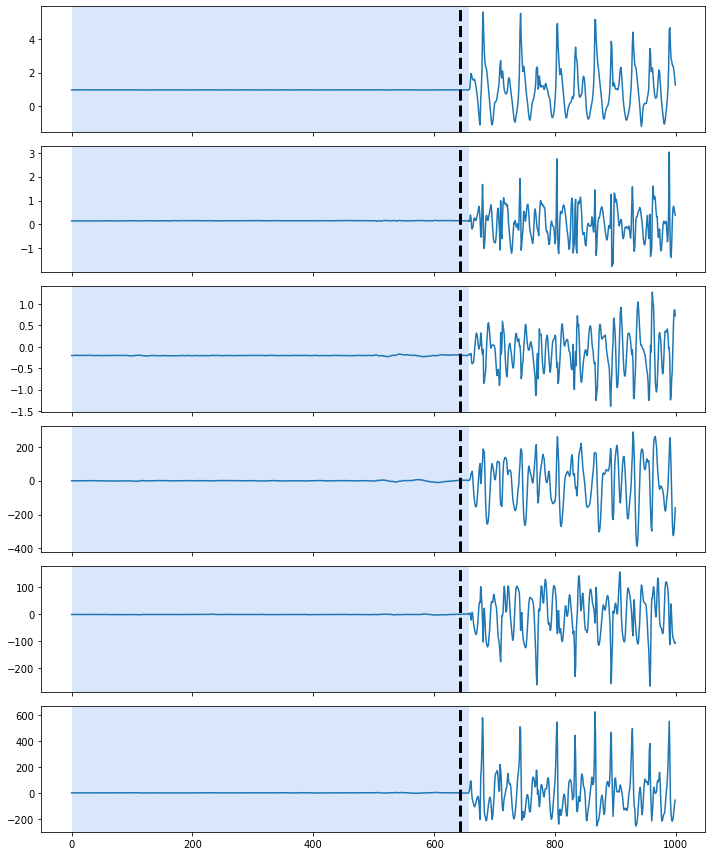

process number: 59
Predicted CP: 644
Real CP: 658


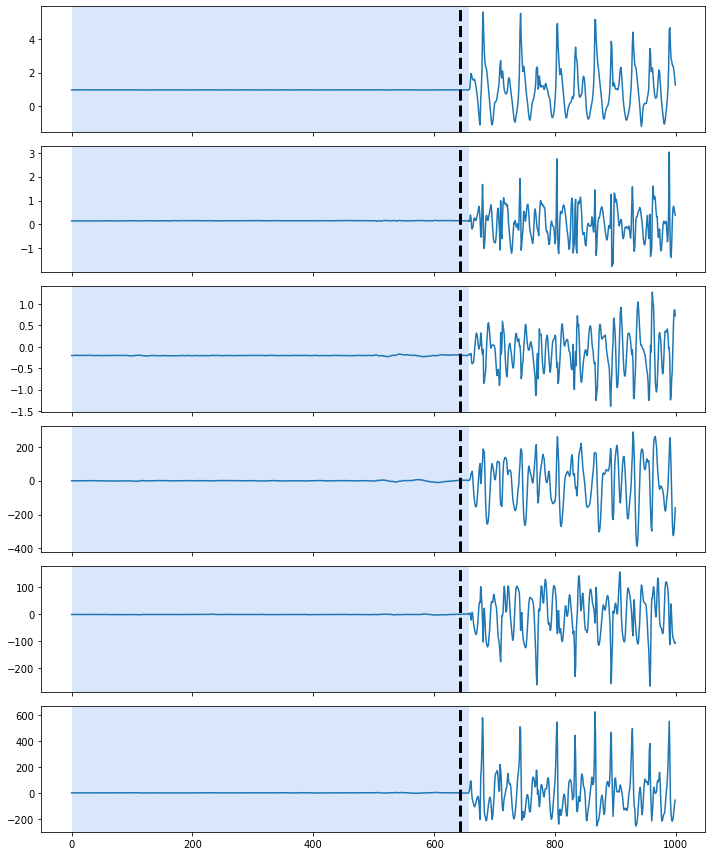

process number: 99
Predicted CP: 644
Real CP: 658


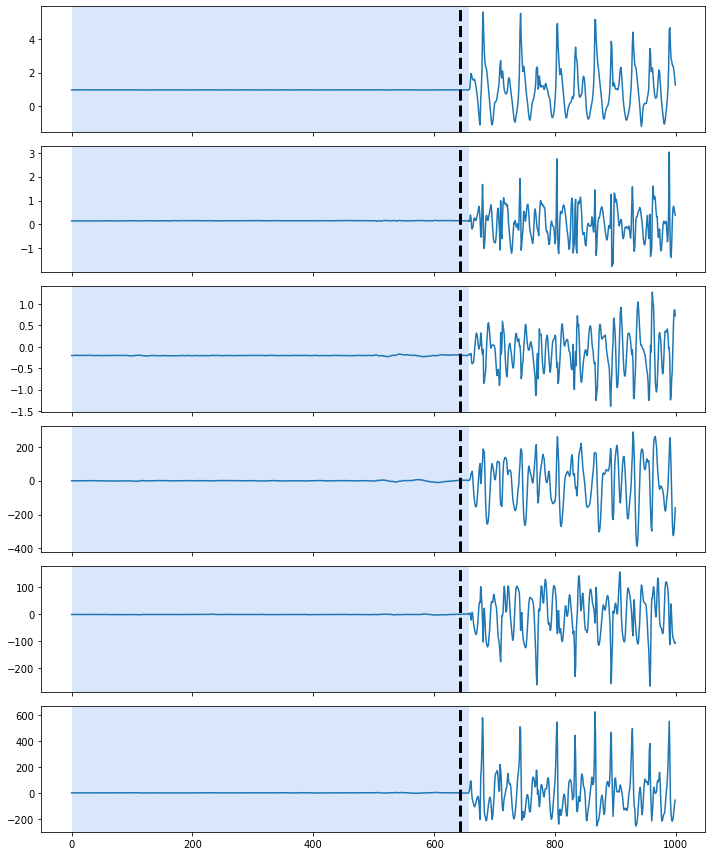

In [126]:
our_diffs = []
y_true = []
y_pred = []
data = data_tt
labels = labels_tt
proc_len = 1000
for ind in range(100):
    X_tt = ((data[data['process_id'] == ind])).iloc[:, 2:]
    y_tt = labels_tt[950 * ind : 950 * (ind + 1)]
    threshold = int(labels.values[ind * n][0] + 30)
    y_tt_pred = (clf.predict(xgb.DMatrix(X_tt)))
    threshold_pred = int(find_by_window(y_tt_pred) + 30)

    y_pred += [0] * threshold_pred 
    y_pred += [1] * (proc_len - threshold_pred)
    
    y_true += [0] * threshold
    y_true += [1] * (proc_len - threshold)

    our_diffs.append(np.abs(threshold - threshold_pred))
    
    if ind in to_draw:
        print('process number:', ind)
        signal = processes[ind].T
        fig, ax = rpt.display(signal, [threshold], [threshold_pred])
        print('Predicted CP:', threshold_pred)
        print('Real CP:', threshold)
        plt.show()
    
bm.loc['mean_diff', 'Custom'] = np.mean(our_diffs)
bm.loc['precision', 'Custom'] = precision_score(np.array(y_true), np.array(y_pred))
bm.loc['recall', 'Custom'] =  recall_score(np.array(y_true), np.array(y_pred))

Here you can observe the results of **BinSeg** change point detection method.




process number: 99
Predicted CP: 660
Real CP: 658


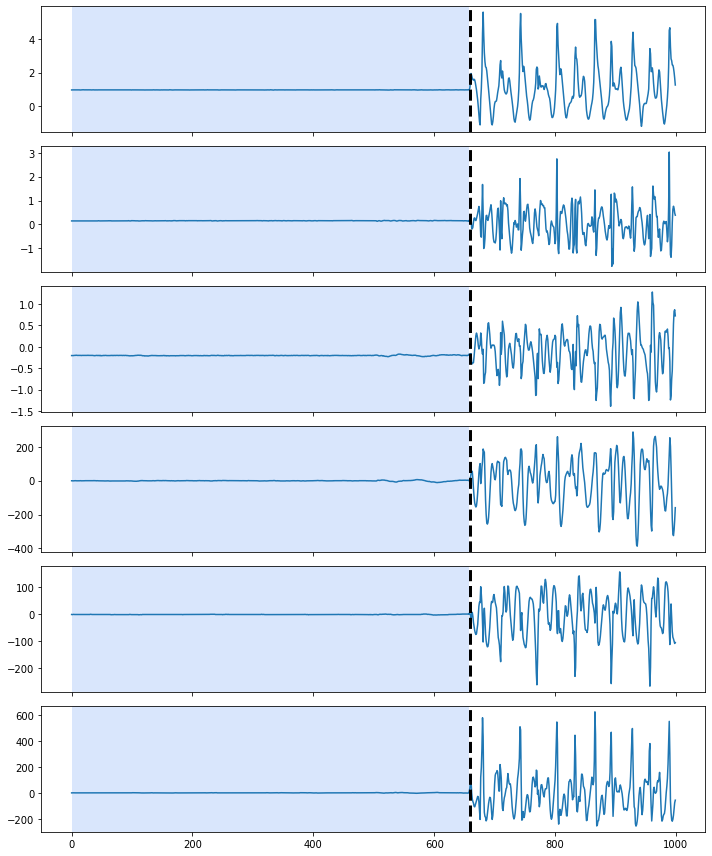

process number: 99
Predicted CP: 660
Real CP: 658


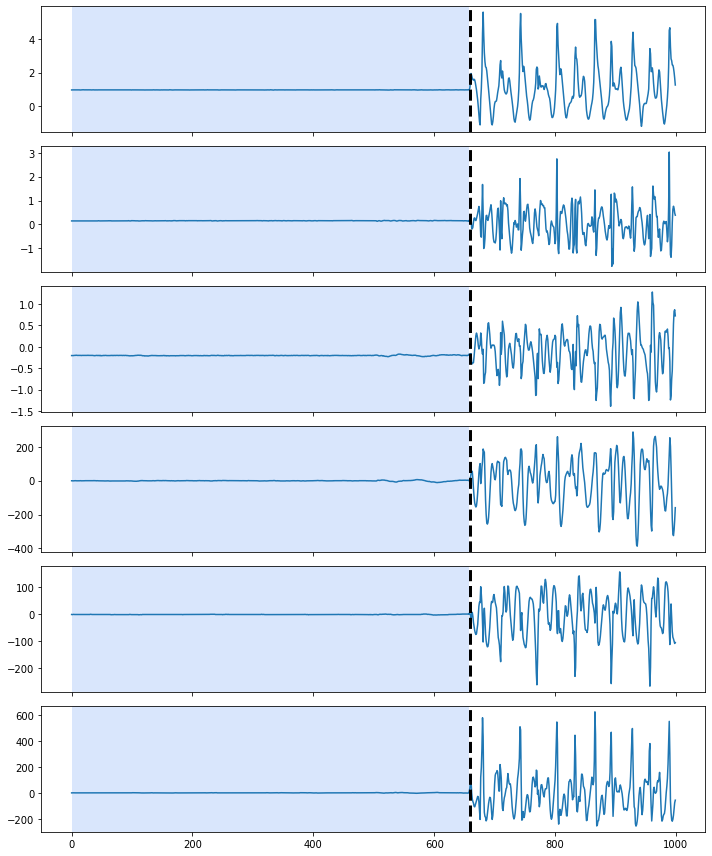

process number: 99
Predicted CP: 660
Real CP: 658


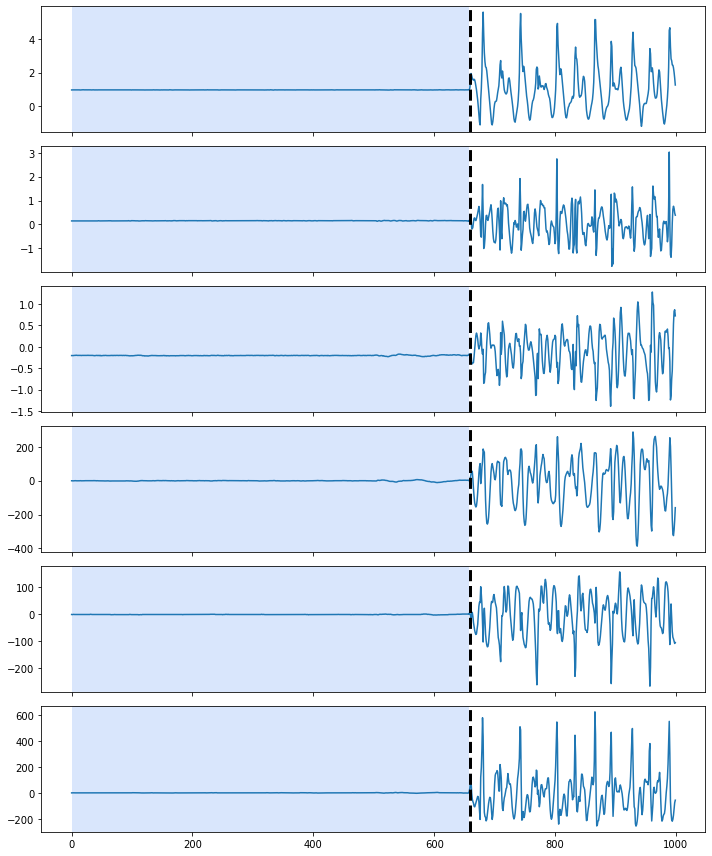

In [127]:
diffs = []
y_pred = []
y_true = []
proc_len = 1000
for ii in range(len(processes)):
    signal = processes[ii].T

    algo = rpt.Binseg(model="rbf").fit(signal)
    result = algo.predict(n_bkps=1)
    y_pred += [0] * result[0] 
    y_pred += [1] * (proc_len - result[0])
    label = np.argmax(proc_labels[ii*proc_len:(ii + 1)*proc_len])
    y_true += [0] * label
    y_true += [1] * (proc_len - label)
    diffs.append(np.abs(result[0] - label))
    
    if ii in to_draw:
        print('process number:', ind)
        fig, ax = rpt.display(signal, [label], result)
        print('Predicted CP:', result[0])
        print('Real CP:', label)
        plt.show()
        
bm.loc['mean_diff', 'BinSeg'] = np.mean(diffs)
bm.loc['precision', 'BinSeg'] = precision_score(np.array(y_true), np.array(y_pred))
bm.loc['recall', 'BinSeg'] =  recall_score(np.array(y_true), np.array(y_pred))

Here you can observe the results of **BottomUp** change point detection method.

process number: 99
Predicted CP: 665
Real CP: 658


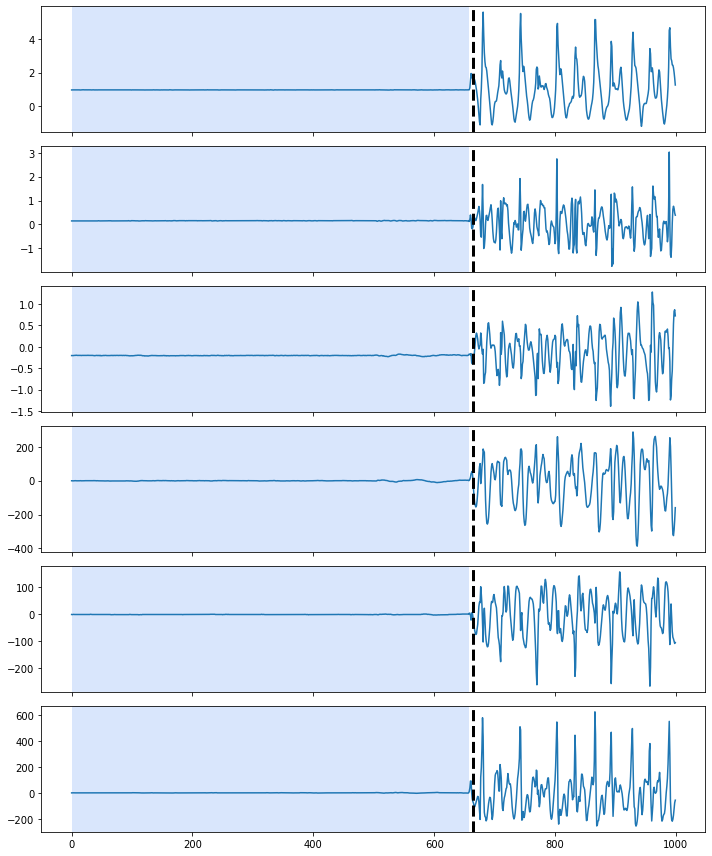

process number: 99
Predicted CP: 665
Real CP: 658


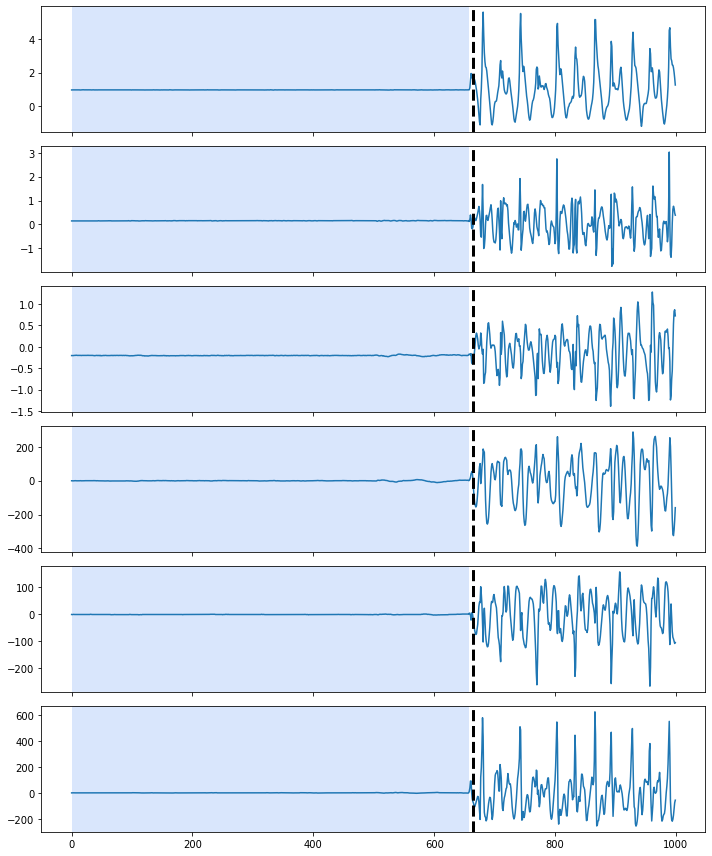

process number: 99
Predicted CP: 665
Real CP: 658


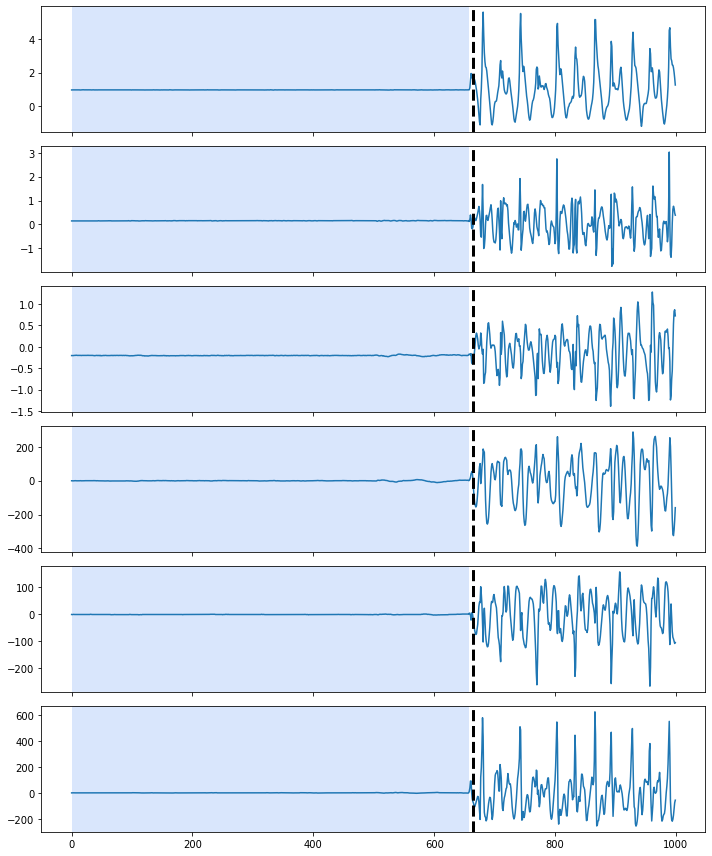

In [128]:
diffs = []
y_pred = []
y_true = []
proc_len = 1000
for ii in range(len(processes)):
    signal = processes[ii].T

    algo = rpt.BottomUp(model="rbf").fit(signal)
    result = algo.predict(n_bkps=1)
    y_pred += [0] * result[0] 
    y_pred += [1] * (proc_len - result[0])
    label = np.argmax(proc_labels[ii*proc_len:(ii + 1)*proc_len])
    y_true += [0] * label
    y_true += [1] * (proc_len - label)
    diffs.append(np.abs(result[0] - label))
    
    if ii in to_draw:
        print('process number:', ind)
        fig, ax = rpt.display(signal, [label], result)
        print('Predicted CP:', result[0])
        print('Real CP:', label)
        plt.show()
    
bm.loc['mean_diff', 'BottomUp'] = np.mean(diffs)
bm.loc['precision', 'BottomUp'] = precision_score(np.array(y_true), np.array(y_pred))
bm.loc['recall', 'BottomUp'] =  recall_score(np.array(y_true), np.array(y_pred))

In [129]:
bm

,Custom,BinSeg,BottomUp
mean_diff,14,2,7
precision,0.960674,1,1
recall,1,0.994152,0.979532
